In [1]:
import gglasso
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

from numpy.linalg import matrix_rank
from matplotlib.pyplot import figure
from scipy import stats
from scipy.linalg import eigh
from numpy import genfromtxt

from gglasso.solver.admm_solver import ADMM_MGL
from gglasso.problem import glasso_problem

from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.helper.basic_linalg import adjacency_matrix
from gglasso.helper.data_generation import time_varying_power_network, sample_covariance_matrix
from gglasso.helper.experiment_helper import lambda_grid, discovery_rate, error
from gglasso.helper.utils import get_K_identity
from gglasso.helper.experiment_helper import plot_evolution, plot_deviation, surface_plot, single_heatmap_animation
from gglasso.helper.model_selection import aic, ebic

In [2]:
df_train = pd.read_csv("train.csv", sep=',')
df_test = pd.read_csv("submission_valid.csv", sep=',')

df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
print("Shape of datasets: \n train - {0}, \n test - {1}, \n merged - {2}".format(df_train.shape, df_test.shape, df.shape))

Shape of datasets: 
 train - (751, 94832), 
 test - (200, 94832), 
 merged - (951, 94832)


In [4]:
sex = df["sex_f0_m1"]
age = df["age"]

In [5]:
df = df.iloc[:, :-2]
df.shape

(951, 94830)

In [6]:
ix_list = []
range_ = np.arange(0,436)
sum_ = sum(range_)

#list of indices where should be 1
for i in range(0, 436):
    ix = sum_ - sum(range(0, 436 - i)) + i
    ix_list.append(ix)

In [7]:
#create an empty list of the shape of data
empty = np.empty([951, 95266], dtype=float)

In [8]:
for i, row in df.iterrows():
    a = np.array(row)
    
    for ix in ix_list:
        a = np.insert(a, ix, 1, axis=0)
    
    empty[i, :] = a

In [9]:
diag_df = pd.DataFrame(empty)
diag_df.shape

(951, 95266)

### From feature vector to correlation matrix

In [10]:
corr = []
for _, i in diag_df.iterrows():
    #split a row to subrows representing columns in corr matrix
    #exclude 0 index from splitting criteria
    items = np.split(i, ix_list[1:])
    
    # get the maximum  col length
    maxlen = len(max(items, key=len))
    
    # pad left of each sublist with NaN to make it as long as the longest
    i = 0
    for item in items:
        nans = np.repeat(np.nan, (maxlen - len(item)))
        item = np.concatenate((nans, item), axis=None)
        items[i] = item
        i += 1
        
    #create upper and lower triangular matrices
    upper = pd.DataFrame.from_records(items)
    lower = upper.T
    
    #full corr matrix
    c = upper.fillna(lower)
    
    corr.append(c)

In [11]:
C = np.array(corr)
C.shape

(951, 436, 436)

In [12]:
ein_counts = []

for i in range(0, C.shape[0]):
    for j in range(0, C.shape[1]):
        if C[i][j].any() >= 1:
            #print("Not a corr value at matrix - {0}".format(i))
            ein_counts.append(1)
        elif C[i][j].any() <= -1:
            #print("Not a corr value at {0}".format(i))
            ein_counts.append(1)
print("If 1 is only at the diagonal: 951*436 = {0}".format(951*436))
print("Total number of ones: {0}".format(np.array(ein_counts).sum()))

If 1 is only at the diagonal: 951*436 = 414636
Total number of ones: 414636


In [13]:
#check if any NaN
pd.DataFrame(C[0]).isnull().values.any()

False

# SPD violation problem 

### Workaround #1

In [24]:
# take first corr matrix as an example
test_C = C[0]
test_C.shape

(436, 436)

In [25]:
tol = 1e-14

#eigendecompsition for symmetric matrix
v, r = eigh(test_C)

# set very small values to 0
v.real[abs(v.real) < tol] = 0.0

#create diag matrix for further matrix multiplication
v = np.diag(v)

In [26]:
v.diagonal()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [27]:
#back to correlation through solving A = rvr*
new_test = r@v@sp.linalg.inv(r)
new_test.shape

(436, 436)

Now, the matrix has to be SPD by the definition since all eigenvalues are non-negative.

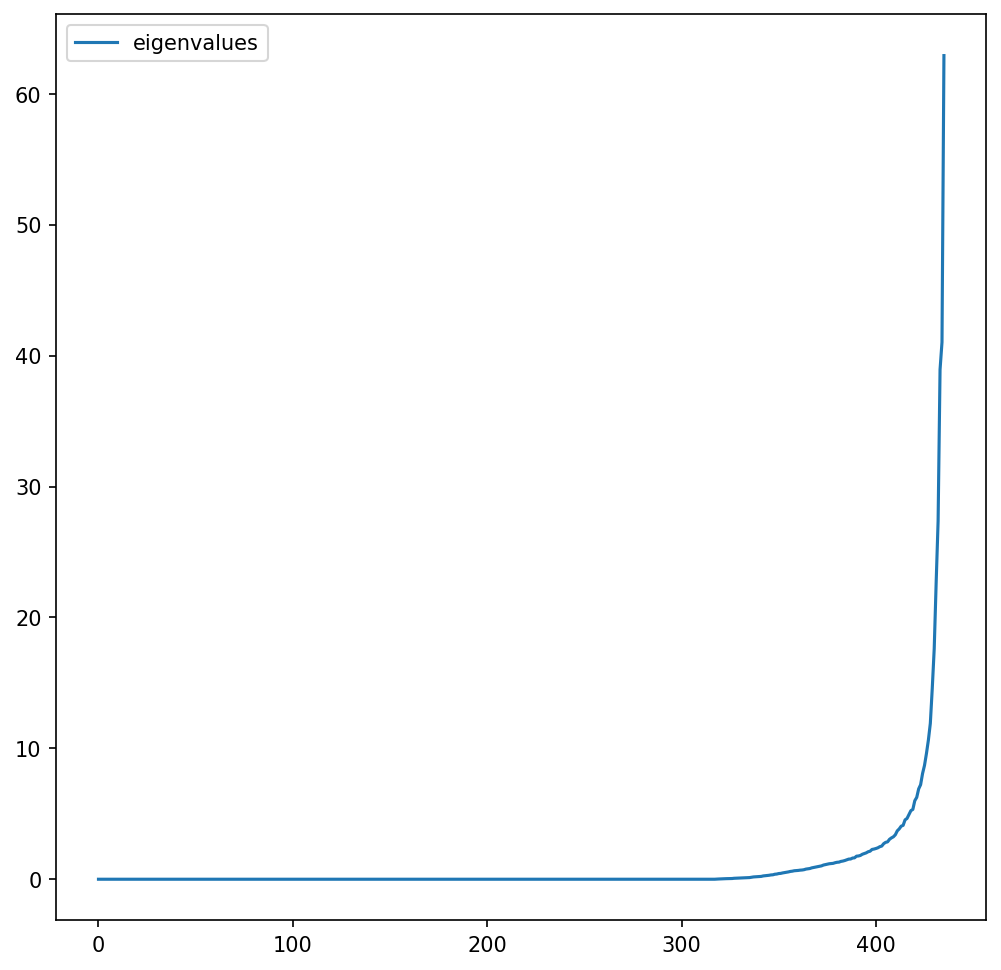

In [28]:
figure(figsize=(8, 8), dpi=150)

plt.plot(v.diagonal(), label="eigenvalues")
# plt.yscale('log')
plt.legend()
plt.show()

However, if we do Choleskiy decomposition of a new matrix, it will still gives us an error since the matrix is not SPD.

Can  this be due to some approximation in Numpy implementation?

In [29]:
# np.linalg.cholesky(new_test)

# a = pd.DataFrame(test_C)
# b = pd.DataFrame(new_test)
# # a.compare(b)

For example, if we do eigendecomposition of a new matrix, we will find very small negative eigenvalues again.

After this small expriment we can see that some of the eigen values are very close to zero, but not absolute zero.

This prevents the matrix to be positive semidefinite, we will set those extremelly small values to 0 and reconstruct correlation matrix. accordingly.

In [30]:
#check if the matrix is SPD
np.linalg.cholesky(test_C)

LinAlgError: Matrix is not positive definite

If the resulting matrix is not semipositive definite, we violates GGLasso constraint.

### Workaround #2

In [14]:
# (436,436) identity matrix
I = np.eye(C.shape[1])

tol_up = 10e-6
tol_low = 10e-14

corr_mod = []

# 951 matrices
for i in range(0, C.shape[0]):
    matrix = C[i]
    
    eigenvalues = eigh(matrix, eigvals_only=True)
    #change negative to zero first and then continue - does not make sense becuase the reproducible matrix will have neagtive eigenvalues again.
    min_positive = np.select(eigenvalues > 0, eigenvalues)
    
    if min_positive > tol_up:
        min_positive = tol_up
    elif min_positive < tol_low:
        min_positive = tol_low
    
    matrix = matrix + I*min_positive
    
    try:
        np.linalg.cholesky(matrix)
        corr_mod.append(matrix)
    except:
        print("Some matrices are not SPD")

In [15]:
corr_mod = np.array(corr_mod)
corr_mod.shape

(951, 436, 436)

In [16]:
# select first 50 corr matrices
sub_corr = corr_mod[:50, :]

sub_corr.shape

(50, 436, 436)

In [21]:
# #dump matrices into csv
# for i in range(0, sub_corr.shape[0]):
#     np.savetxt("/storage/groups/bds01/datasets/brains/sub_corr50/sub_corr{0}.csv".format(i), sub_corr[i], delimiter=",", header='')

### Semi-positive definite matrix

Run for 50 matrices first

In [33]:
N = corr_mod.shape[1]
N

436

In [34]:
P = glasso_problem(corr_mod[:50, :], N, reg_params = {'lambda1': 0.05}, latent = True, do_scaling = False)
print(P)

 
GROUP GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': 0.05, 'lambda2': 0.01, 'mu1': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])}


In [35]:
lambda1_range = np.logspace(0, -1, 5)
mu1_range = np.logspace(0, -1, 5)
modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.25)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

------------Range search for instance 0------------
ADMM terminated after 52 iterations with status: optimal.
ADMM terminated after 89 iterations with status: optimal.
ADMM terminated after 102 iterations with status: optimal.
ADMM terminated after 123 iterations with status: optimal.
ADMM terminated after 258 iterations with status: optimal.
ADMM terminated after 132 iterations with status: optimal.
ADMM terminated after 88 iterations with status: optimal.
ADMM terminated after 103 iterations with status: optimal.
ADMM terminated after 124 iterations with status: optimal.
ADMM terminated after 267 iterations with status: optimal.
ADMM terminated after 135 iterations with status: optimal.
ADMM terminated after 88 iterations with status: optimal.
ADMM terminated after 102 iterations with status: optimal.
ADMM terminated after 125 iterations with status: optimal.
ADMM terminated after 270 iterations with status: optimal.
ADMM terminated after 144 iterations with status: optimal.
ADMM ter

In [ ]:
#tmp = P.modelselect_stats
sol = P.solution.precision_
P.solution.calc_adjacency(t = 1e-4)

In [160]:
# reg = "FGL"
# lambda1 = 0.002
# lambda2 = 0.002
# mu1 = 0.01


# K = corr.shape[0]
# p = corr.shape[1]

# Omega_0 = get_K_identity(K,p)
# Theta_0 = get_K_identity(K,p)
# X_0 = np.zeros((K,p,p))

# sol, info = ADMM_MGL(SPD, lambda1, lambda2, reg, Omega_0, Theta_0 = Theta_0, X_0 = X_0, tol = 1e-8, rtol = 1e-8, mu1=mu1, latent=True,verbose = True, measure = False)

In [39]:
sol.shape

(50, 436, 436)

In [49]:
Omega = P.solution.precision_
L = P.solution.lowrank_
S = P.solution.sample_covariance_

In [51]:
Omega.shape, L.shape, S.shape

((50, 436, 436), (50, 436, 436), (50, 436, 436))

In [60]:
Omega[49].shape

(436, 436)

In [61]:
#dump matrices into csv
# for i in range(0, 50):
#     np.savetxt("output/Omega{0}.csv".format(i), Omega[i], delimiter=",", header='')
#     np.savetxt("output/L{0}.csv".format(i), L[i], delimiter=",", header='')
#     np.savetxt("output/S{0}.csv".format(i), S[i], delimiter=",", header='')

In [5]:
# my_data = genfromtxt('my_file.csv', delimiter=',')

In [18]:
#read csv and convert them to numpy back

Omega = []
L = []
S = []

for i in range(0, 50):
    Omega.append(genfromtxt("output/Omega{0}.csv".format(i), delimiter=','))
    L.append(genfromtxt("output/L{0}.csv".format(i), delimiter=','))
    S.append(genfromtxt("output/S{0}.csv".format(i), delimiter=','))
    

Omega = np.array(Omega)
L = np.array(L)
S = np.array(S)

In [57]:
# theta = open('Theta.pkl', 'wb')
# pickle.dump(sol["Theta"], theta)
# theta.close()

In [58]:
# omega = open('Omega.pkl', 'wb')
# pickle.dump(sol["Omega"], omega)
# omega.close()

In [59]:
# L_list = open('L.pkl', 'wb')
# pickle.dump(sol["L"], L_list)
# L_list.close()

In [60]:
# X_list = open('X.pkl', 'wb')
# pickle.dump(sol["X"], X_list)
# X_list.close()

In [164]:
# matrix_rank(sol["L"])

In [12]:
sns.set(rc={'figure.figsize':(15,15)})

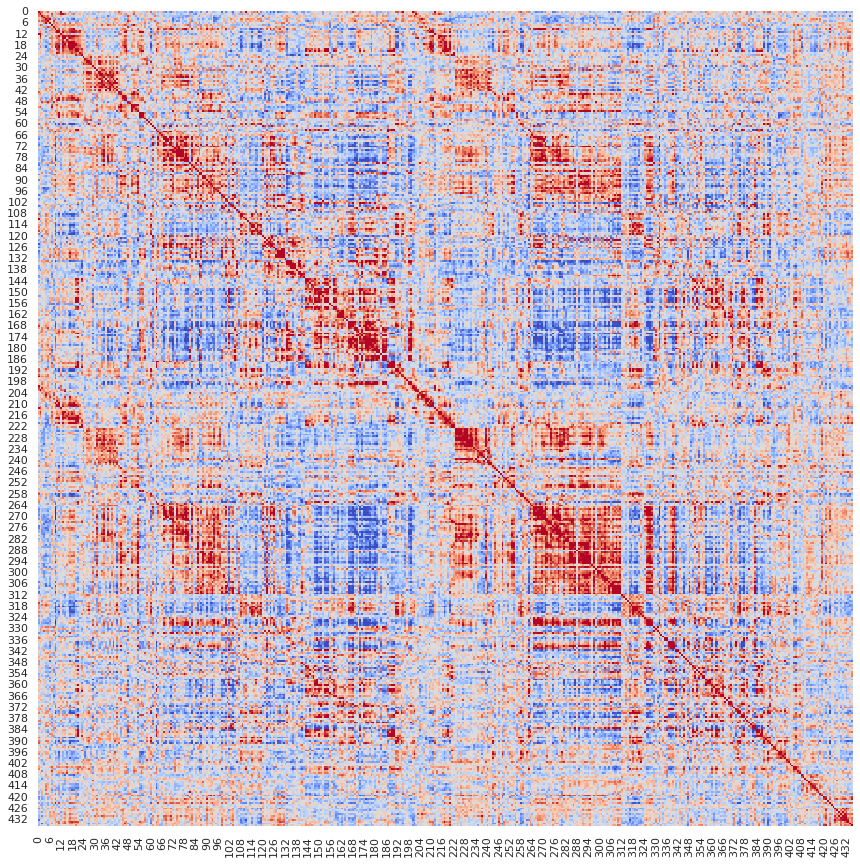

In [168]:
ax = sns.heatmap(corr_mod[0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

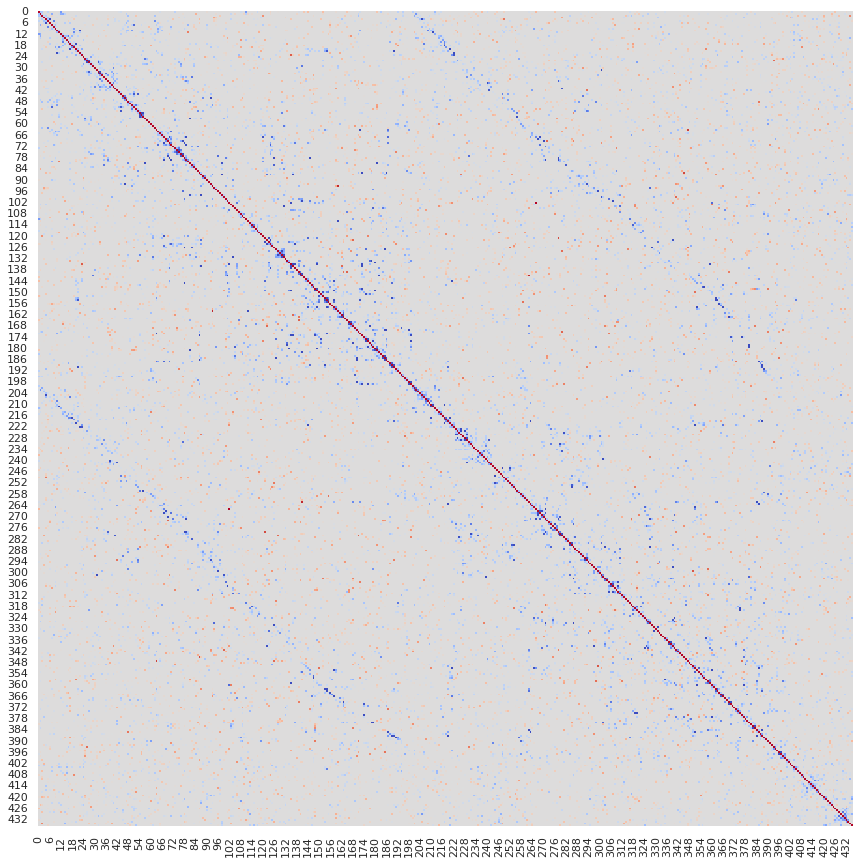

In [167]:
ax = sns.heatmap(sol[0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

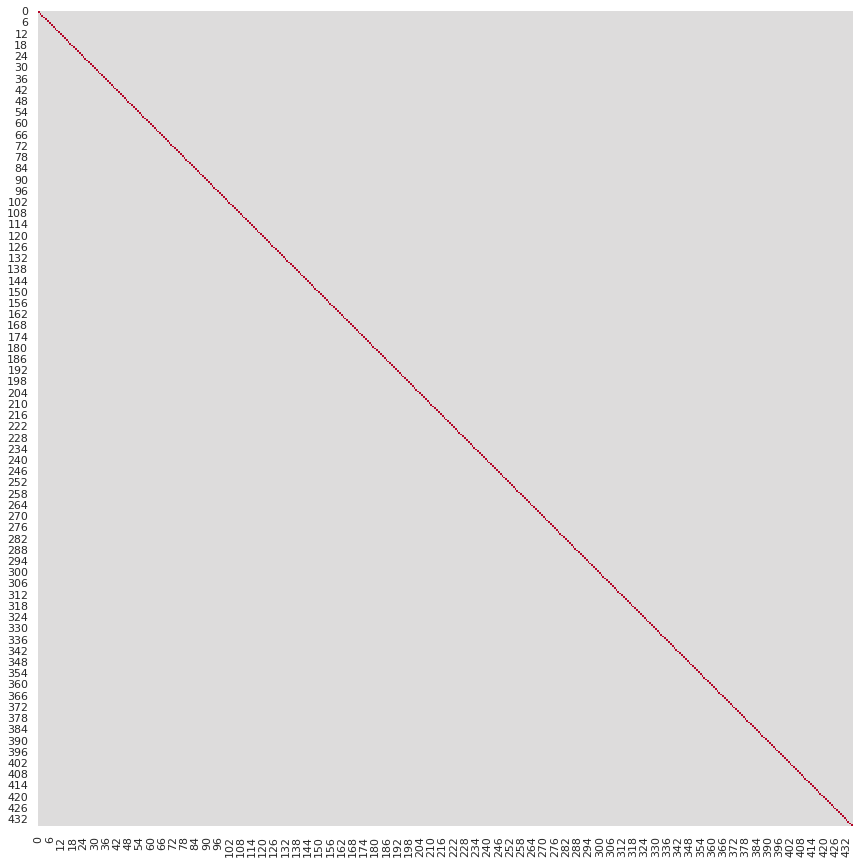

In [21]:
ax = sns.heatmap(Omega[0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

In [169]:
# ax = sns.heatmap(sol["L"][0,:], center=0, vmin = -0.5, vmax = 0.5, square = True, cbar = False, cmap = "coolwarm")

In [25]:
# sparse = open("sparse.txt", "w")
# for row in sol["Theta"]:
#     np.savetxt(sparse, row)

# sparse.close()

## RobustPCA

In [69]:
age.shape, sex.shape

((951,), (951,))

In [70]:
def robust_PCA(X, L, inverse=True):
    sig, V = np.linalg.eigh(L)

    # sort eigenvalues in descending order
    sig = sig[::-1]
    V = V[:,::-1]

    ind = np.argwhere(sig > 1e-9)

    if inverse:
        loadings = V[:,ind] @ np.diag(np.sqrt(1/sig[ind]))
    else:
        loadings = V[:,ind] @ np.diag(np.sqrt(sig[ind]))

    # compute the projection
    zu = X.T @ loadings

    return zu, loadings, np.round(sig[ind].squeeze(),3)

In [71]:
L = np.array(sol["L"])[0,:]
proj, loadings, eigv = robust_PCA(SPD[0,:], L, inverse=True)
r = np.linalg.matrix_rank(L)
print(r)

361


In [72]:
proj.shape

(436, 361)

## Age vs. PC1

In [73]:
proj[:,0].shape, age.shape

((436,), (951,))

Spearman correlation between age and 1st component: 0.06230178148091764, p-value: 0.5380373679341799


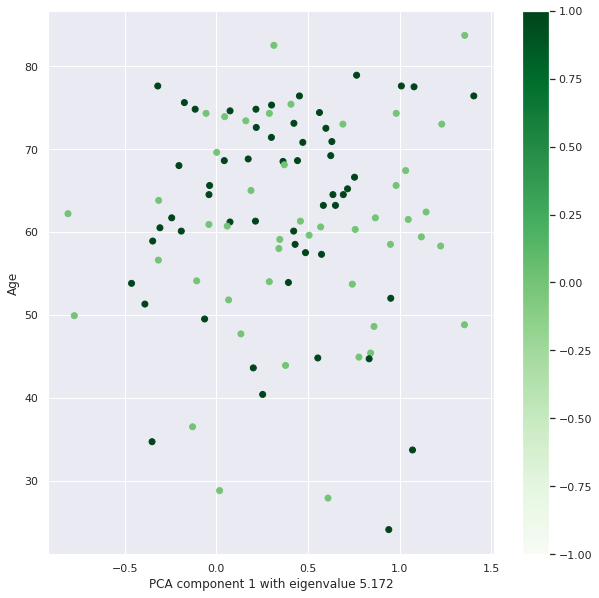

In [70]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(proj[:100,0], age,c = sex, cmap = plt.cm.Greens, vmin = -1)
cbar = fig.colorbar(im)
ax.set_xlabel(f"PCA component 1 with eigenvalue {eigv[0]}")
ax.set_ylabel("Age")

print("Spearman correlation between age and 1st component: {0}, p-value: {1}".format(stats.spearmanr(age, proj[:100,0])[0],
                                                                              stats.spearmanr(age, proj[:100,0])[1]))

## Sex vs. PC2

Spearman correlation between sex and 2st component: -0.12024932472280177, p-value: 0.23337703930034825


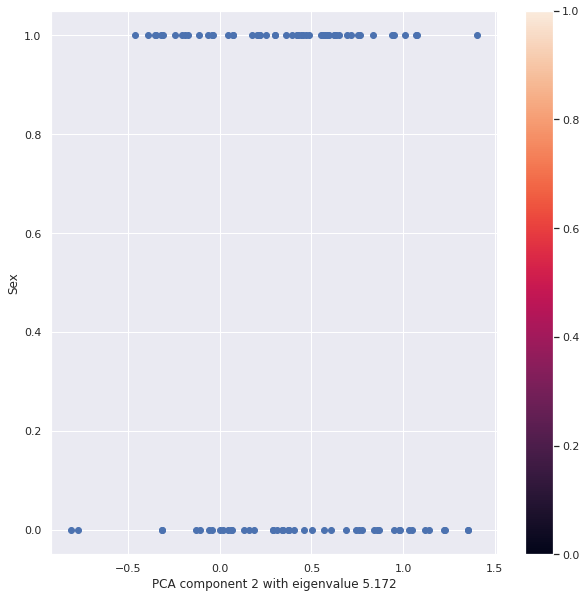

In [64]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(proj[:100,0], sex, cmap = plt.cm.Blues, vmin = 0)
cbar = fig.colorbar(im)
ax.set_xlabel(f"PCA component 2 with eigenvalue {eigv[0]}")
ax.set_ylabel("Sex")

print("Spearman correlation between sex and 2st component: {0}, p-value: {1}".format(stats.spearmanr(sex, proj[:100,0])[0],
                                                                              stats.spearmanr(sex, proj[:100,0])[1]))